[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*******************

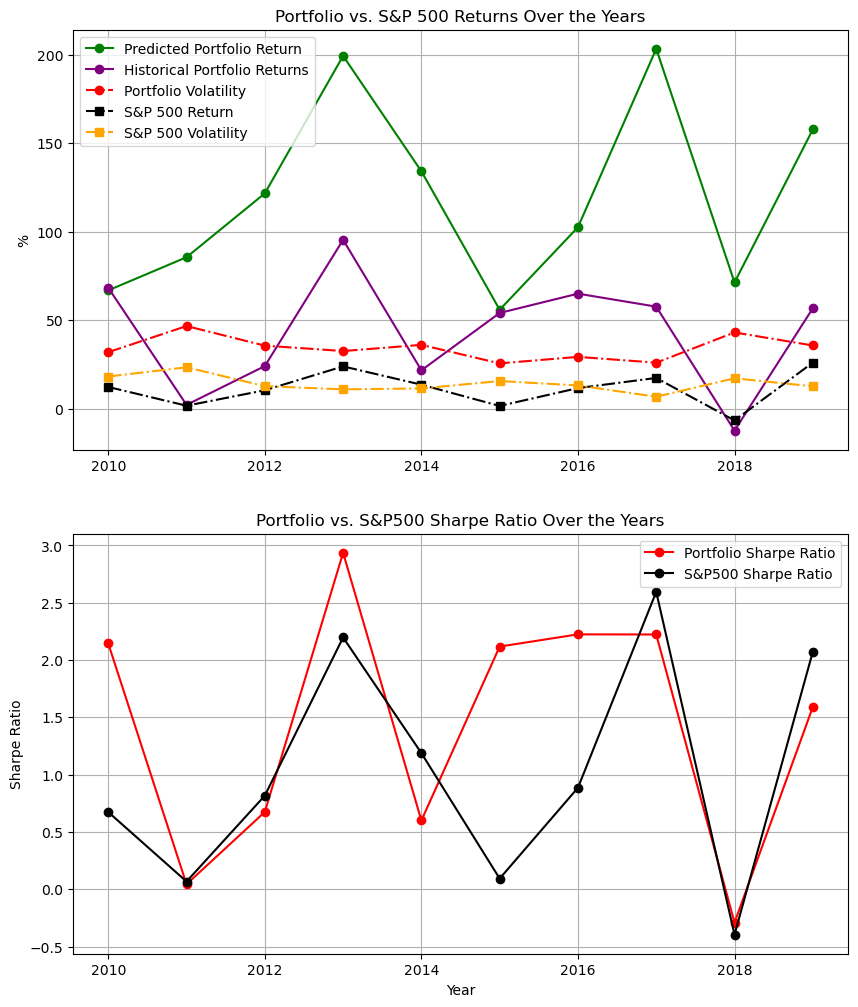

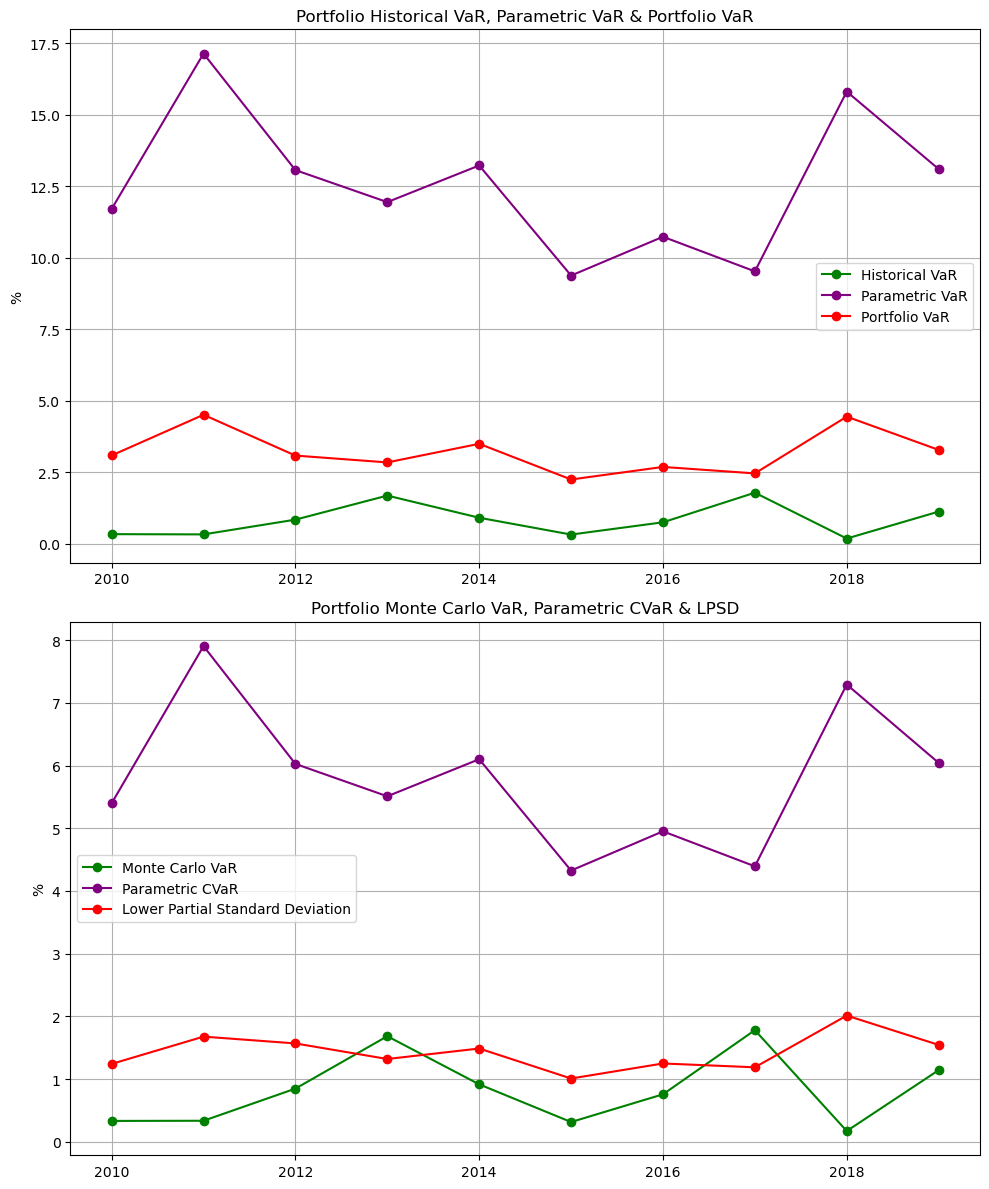

In [17]:
## IMPORT MODULES

import pandas as pd
import numpy as np
import yfinance as yf
from pypfopt import expected_returns, risk_models, EfficientFrontier
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt


## SET ASSUMPTIONS AND VARIABLES

confidence_level = 0.05  
# 95% confidence level
# This sets a level of risk tolerance
# Assuming normality & not accounting for Black Swan Events
# i.e. 0 Skew & 0 Excess Kurtosis

time_horizon = 1  # 1 day
initial_portfolio_value = 100 # Percentage Returns

risk_free_rate = (0.053/250) - 1 
# The appropriate rate is a US treasury bond of the investment duration
# Can get this through an API 

n_simulations = 10000
# Not related to the trading frequency of the relevant exchange 


## DEFINE FUNCTIONS

def fetch_historical_data(assets, start_date, end_date):
    if len(assets) == 1:
        # Wrap the Series in a DataFrame for consistency
        data = pd.DataFrame(yf.download(assets, start=start_date, end=end_date)['Adj Close'])
    else:
        data = yf.download(assets, start=start_date, end=end_date)['Adj Close']
    return data


    
# Mean-variance optimization for optimal portfolio weights:

def calculate_portfolio_metrics(data, risk_free_rate):
    # Calculate daily asset returns and remove first NaN row.
    returns = data.pct_change().dropna()
    
    # Calculate returns predicted by CAPM.
    predicted_asset_returns = expected_returns.capm_return(data, risk_free_rate=risk_free_rate, frequency=252)
    # The optimization is mathematically sound but dependant on input parameters.
    # 'predicted_asset_returns' can be improved using Black-Litterman Allocation.
    
    # Calculate the covariance matrix of returns.
    # Default assumes price data.
    cov_matrix = risk_models.sample_cov(returns, returns_data=True)
    
    # Create an instance of the EfficientFrontier class.
    ef = EfficientFrontier(predicted_asset_returns, cov_matrix)
    
    # Calculate optimal portfolio weights to maximize Sharpe ratio.    
    weights = ef.max_sharpe()
    # Can add in constraints and optimise according to IPS.
    # Review pypfopt library for additional optimization specifications.
    
    # Mean-Variance Optimization (highest return for lowest volatility).
    # Calculates expected return, (historical) volatility and (Expected) Sharpe ratio.
    portfolio_expected_return, volatility, sharpe_ratio = ef.portfolio_performance()
    # Where Volatility = returns.dot(optimal_weights).std() * np.sqrt(252) * 100

    # Assign 'weight` values dictionary to the `optimal_weights` as list.
    optimal_weights = list(weights.values())
    # Max Capital Allocation: Sum of weights = 1.
    weights_sum = sum(optimal_weights)
    # Can adjust this so some of the capital remains in the Rf asset
    
    # Calculate historical portfolio daily returns
    historic_portfolio_returns = returns.dot(optimal_weights)
    
    # Annualize the returns
    annual_portfolio_returns = historic_portfolio_returns.mean() * 252
    
    #Calculate Historic Sharpe Ratio.
    historic_sharpe_ratio = annual_portfolio_returns/volatility

    
    return {
        "Historical Returns": returns,
        "Expected Asset Returns": predicted_asset_returns,
        "Covariance Matrix": cov_matrix,
        "Efficient Frontier": ef,
        "Expected Portfolio Return": portfolio_expected_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Historic Sharpe Ratio": historic_sharpe_ratio,
        "Asset Weights": optimal_weights,
        "Sum of Weights": weights_sum,
        "Historical Portfolio Returns": historic_portfolio_returns,
        "Annual Portfolio Returns": annual_portfolio_returns
    }


def calculate_risk_measures(returns, predicted_asset_returns, cov_matrix, ef, optimal_weights,
                            initial_portfolio_value, portfolio_expected_return, volatility,
                            historic_portfolio_returns,
                            n_simulations=10000, time_horizon=1, confidence_level=0.05):
    
    # 1) Historical VaR: Historical simulation
    
    # Number of Monte Carlo simulations
    n_simulations = 10000

    # Initialize an empty list to store portfolio returns
    portfolio_returns = []

    for _ in range(n_simulations):
        # Generate random returns for each asset using normal distribution
        random_returns = np.random.normal(portfolio_expected_return, volatility, len(assets))

        # Calculate the portfolio return for each simulation
        portfolio_return = np.dot(random_returns, optimal_weights)

        # Append the portfolio return to the list
        portfolio_returns.append(portfolio_return)

    # Calculate the VaR based on the simulated portfolio returns
    sorted_portfolio_returns = sorted(portfolio_returns)
    var_index = int(n_simulations * confidence_level)
    historical_portfolio_var = sorted_portfolio_returns[var_index]

    
    # 2) Parametric VaR:
    
    # Forward-looking using expected return and volatility.
    
    # Call `portfolio_performance()` method to calculate variables. 
    portfolio_expected_return, volatility, _ = ef.portfolio_performance()
    
    # Calculate number of standard deviations from mean. Assumes Normality.
    z_score = norm.ppf(1 - confidence_level)
    parametric_var = volatility * z_score * np.sqrt(time_horizon) * 100
    
    # Calculate value below which actual portfolio return is expected to fall
    # with a certain confidence level based on the distribution of 
    # expected portfolio returns.
    portfolio_var = -np.percentile(portfolio_metrics["Historical Portfolio Returns"], confidence_level * 100) * 100

    
    # 3) Monte Carlo simulation: 
    
    # Uses Forward-looking expected return, Backward-looking volatility.
    # Takes the asset std dev from the cov matrix diagonals. Assumes Normality.
    
    portfolio_values = []

    for _ in range(n_simulations):
        # Generate random returns for each asset using normal distribution
        random_returns = np.random.normal(portfolio_expected_return, volatility, len(assets))

        # Calculate the portfolio return for the time horizon
        portfolio_return = np.dot(random_returns, optimal_weights)

        # Calculate the portfolio value at the end of the time horizon
        portfolio_value = initial_portfolio_value * (1 + portfolio_return)

        portfolio_values.append(portfolio_value)
    
    # Calculate the VaR
    sorted_portfolio_values = np.sort(portfolio_values)
    var_index = int(n_simulations * confidence_level)
    monte_carlo_var = -(initial_portfolio_value - sorted_portfolio_values[var_index]) / initial_portfolio_value
    

    # 4) Parametric CVaR (Expected Shortfall): 
    
    # Weighted average of “extreme” losses in tail of distribution of returns, 
    # beyond (VaR) cutoff point. Assumes Normality.
    parametric_cvar = (volatility * z_score / np.sqrt(2 * np.pi)) * np.exp(-(z_score ** 2) / 2) * 100

    # 5) LPSD (Lower Partial Standard Deviation)
    
    # Only consider negative returns.
    threshold = 0
 
    lpsd = np.std(historic_portfolio_returns[historic_portfolio_returns<threshold]) * 100

    return {
    "Historical VaR": historical_portfolio_var,
    "Parametric VaR": parametric_var,
    "Portfolio VaR": portfolio_var,
    "Monte Carlo VaR": monte_carlo_var,
    "Parametric CVaR": parametric_cvar,
    "LPSD": lpsd
    }

    
## CHOOSE INPUT DATA FOR FUNCTIONS TO RUN THROUGH
    
# Define assets:
assets = ["AAPL", "AMZN","NVDA", "GOOGL","TSLA","UNH","LLY","XOM","JPM","V","JNJ"]
# Choose these assets based on favourable ratios for a given economic outlook.
# , "MSFT"

# Benchmark:
sp500 = "^GSPC" # S&P 500 symbol - Pool form which the asset list was selected.

# Used for start_date, end_date:
start_year = 2010
end_year = 2020
# Long look-back period provides more reliability if we assume history is repeated.
# Incorporates a look-back selection bias for stocks which have survived.
# Nearly 180 stocks in the S&P 500 have been replaced since 2015.
# Given enough computing power, the assets list can be the whole S&P 500.


## INITIALIZE LISTS TO STORE OUTPUT DATA

years = []

portfolio_annual_returns = []
historical_portfolio_returns = []
volatilities = []
sharpe_ratios = []

sp500_annual_returns = []
sp500_annual_volatility = []
sp500_sharpe_ratios = []

historical_portfolio_var_list = []
parametric_var_list = []
portfolio_var_list = []
monte_carlo_var_list = []
parametric_cvar_list = []
lpsd_list = []


## LOOP THROUGH DATA AND STORE OUTPUTS

for year in range(start_year, end_year):
    # Define start_date and end_date based on the current year:
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    # Choose this rolling window based on your portfolio rebalancing time-frame.

    # Fetch historical data for the current year:
    data = fetch_historical_data(assets, start_date, end_date)
    

    # Calculate Portfolio Metrics for the current year:
    portfolio_metrics = calculate_portfolio_metrics(data, risk_free_rate)
    
    # Append the data to the lists:
    
    portfolio_annual_returns.append(portfolio_metrics['Expected Portfolio Return'] * 100)  # Convert to percentage

    historical_portfolio_returns.append(portfolio_metrics["Annual Portfolio Returns"] * 100)  

    volatilities.append(portfolio_metrics["Volatility"] * 100)
    
    sharpe_ratios.append(portfolio_metrics["Historic Sharpe Ratio"])
    
    
    # (This section could be a def calculate_benchmark function for reusability.)
    
    # Caculate the Benchmark Return and volatility:
    sp500_returns = fetch_historical_data(sp500, start_date, end_date).pct_change().dropna() * 100
    sp500_annual_return = sp500_returns.mean() * 252
    sp500_annual_returns.append(sp500_annual_return)  # Convert to annual percentage
    
    # Calcualte Annualize daily volatility:
    sp500_volatility = sp500_returns.std() * np.sqrt(252)
    sp500_annual_volatility.append(sp500_volatility)
    
    # Calculate SP500 Sharp Ratio:
    sp500_sharpe_ratio = (sp500_annual_return/sp500_volatility)
    sp500_sharpe_ratios.append(sp500_sharpe_ratio)
    # Number of trading days per year change, but these are fairly consistent
    # with published values.
  

    # Measure VaR of portfolio:
    risk_measures = calculate_risk_measures(portfolio_metrics["Historical Returns"],
                                            portfolio_metrics["Expected Asset Returns"],
                                            portfolio_metrics["Covariance Matrix"],
                                            portfolio_metrics["Efficient Frontier"],
                                            portfolio_metrics["Asset Weights"],
                                            initial_portfolio_value,
                                            portfolio_metrics["Expected Portfolio Return"],
                                            portfolio_metrics["Volatility"],
                                            portfolio_metrics["Historical Portfolio Returns"],
                                            n_simulations,
                                            confidence_level)
        
    # Append the data to the lists:
    
    historical_portfolio_var_list.append(risk_measures["Historical VaR"])
    parametric_var_list.append(risk_measures["Parametric VaR"])
    portfolio_var_list.append(risk_measures["Portfolio VaR"])
    monte_carlo_var_list.append(risk_measures["Monte Carlo VaR"])
    parametric_cvar_list.append(risk_measures["Parametric CVaR"])
    lpsd_list.append(risk_measures["LPSD"])
        
    years.append(year)
    

## CALCULATE AGGREGATE DATA:

average_volatility = sum(volatilities) / len(volatilities)

average_sharpe_ratio = sum(sharpe_ratios) / len(sharpe_ratios)

average_return = sum(historical_portfolio_returns) / len(historical_portfolio_returns)
# Use the Geometric return if you want the compunded Rate of Return.


## DISPLAY RESULTS

print("Average Portfolio Metrics:\nReturn: {:.2f}%\nVolatility: {:.2f}%\nSharpe Ratio: {:.2f}".format(average_return, average_volatility, average_sharpe_ratio))

# Plot Historical + Predicted Portfolio Return & Volatility vs. Benchmark:

# Create subplots:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.plot(years, portfolio_annual_returns, color='green', marker='o', linestyle='-', label="Predicted Portfolio Return")
ax1.plot(years, historical_portfolio_returns, color='purple', marker='o', linestyle='-', label="Historical Portfolio Returns")
ax1.plot(years, volatilities, color='red', marker='o', linestyle='-.', label="Portfolio Volatility")
ax1.plot(years, sp500_annual_returns, color='black', marker='s', linestyle='-.', label='S&P 500 Return')
ax1.plot(years, sp500_annual_volatility, color='orange', marker='s', linestyle='-.', label='S&P 500 Volatility')

ax1.set_title('Portfolio vs. S&P 500 Returns Over the Years')
ax1.set_ylabel('%')
ax1.grid()
ax1.legend()


# Plot Portfolio Sharpe Ratio versus S&P500:
ax2.plot(years, sharpe_ratios, marker='o', color='red', label = "Portfolio Sharpe Ratio")
ax2.plot(years, sp500_sharpe_ratios, marker='o', color='black', label = "S&P500 Sharpe Ratio")

ax2.set_title('Portfolio vs. S&P500 Sharpe Ratio Over the Years')
ax2.set_xlabel('Year')
ax2.set_ylabel('Sharpe Ratio')
ax2.grid()
ax2.legend()

plt.show()

print(

# Plot Portfolio VaR Measures:

# Create subplots:
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 12))

# Plot Historical VaR, Parametric VaR & Portfolio VaR:
ax3.plot(years, historical_portfolio_var_list, color='green', marker='o', linestyle='-', label="Historical VaR")
ax3.plot(years, parametric_var_list, color='purple', marker='o', linestyle='-', label="Parametric VaR")
ax3.plot(years, portfolio_var_list, color='red', marker='o', linestyle='-', label="Portfolio VaR")

ax3.set_title('Portfolio Historical VaR, Parametric VaR & Portfolio VaR')
ax3.set_ylabel('%')
ax3.grid()
ax3.legend()

# Plot Monte Carlo VaR, Parametric CVaR & LPSD:
ax4.plot(years, monte_carlo_var_list, color='green', marker='o', linestyle='-', label="Monte Carlo VaR")
ax4.plot(years, parametric_cvar_list, color='purple', marker='o', linestyle='-', label="Parametric CVaR")
ax4.plot(years, lpsd_list, color='red', marker='o', linestyle='-', label="Lower Partial Standard Deviation")

ax4.set_title('Portfolio Monte Carlo VaR, Parametric CVaR & LPSD')
ax4.set_ylabel('%')
ax4.grid()
ax4.legend()

plt.tight_layout()

plt.show()